## Visualize WoFCast Predictions

In [1]:
import sys, os 
sys.path.insert(0, os.path.dirname(os.path.dirname(os.getcwd())))

from wofscast.model import WoFSCastModel

Available devices: [cuda(id=1)]


In [2]:
# For plotting. 
import os
import numpy as np
import xarray 
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

from wofscast.plot import WoFSColors, WoFSLevels
from datetime import datetime
import pandas as pd

def to_datetimes(path, n_times = 13):  
    name, freq, ens_mem = os.path.basename(path).split('__')
    start_time_dt = datetime.strptime(name.split('_to')[0], 'wrfwof_%Y-%m-%d_%H%M%S')
    start_time = pd.Timestamp(start_time_dt)
    
    dt_list = pd.date_range(start=start_time, periods=n_times, freq=freq)
    return dt_list[2:]

display_name_mapper = {'U' : 'U-wind Comp.', 
          'V' : 'V-wind Comp.', 
          'W' : 'Vert. Velocity',
          'T' : 'Pot. Temp.', 
          'GEOPOT' : 'Geopot. Height',
          'QVAPOR' : 'QVAPOR', 
          'T2' : '2-m Temp.', 
          'COMPOSITE_REFL_10CM' : 'Comp. Refl.',
          'UP_HELI_MAX' : '2-5 km UH', 
          'RAIN_AMOUNT' : 'Rain Rate'
          
         }

units_mapper = {'T': 'K', 
                'QVAPOR': 'kg/kg', 
                'T2': 'K', 
                'U': 'm/s', 
                'V': 'm/s', 
                'W': 'm/s', 
                'GEOPOT': 'm', 
                'RAIN_AMOUNT': 'in', 
                'COMPOSITE_REFL_10CM': 'dBZ'
               }

## Predict with WoFS-Cast

In [3]:
%%time 
#MODEL_PATH = '/work/mflora/wofs-cast-data/model/wofscast_baseline_full_v2.npz'

MODEL_PATH = '/work/mflora/wofs-cast-data/model/wofscast_with_transformer.npz'

model = WoFSCastModel(domain_size=150, tiling=None)
model.load_model(MODEL_PATH)

#base_path = '/work/mflora/wofs-cast-data/datasets_2hr/2021'
base_path = '/work/mflora/wofs-cast-data/full_domain_datasets/2021'

#name = 'wrfwof_2021-05-13_230000_to_2021-05-14_011000__10min__ens_mem_05.nc'

# Case I've kept showing everyone
#name = 'wrfwof_2021-05-15_020000_to_2021-05-15_041000__10min__ens_mem_09.nc'

# Messy Convection over TX
#name = 'wrfwof_2021-05-07_210000_to_2021-05-07_231000__10min__ens_mem_15.nc'

#name = 'wrfwof_2021-05-10_230000_to_2021-05-11_011000__10min__ens_mem_01.nc'

name = 'wrfwof_2021-06-03_230000_to_2021-06-04_011000__10min__ens_mem_09.nc'

path = os.path.join(base_path, name)
dataset = xarray.load_dataset(path)

dataset = dataset.isel(lon=slice(150-25, 300-25), lat=slice(150-25, 300-25))

inputs, targets, forcings = model.get_inputs(dataset)
predictions = model.predict(inputs, targets, forcings)

# For 2 hr of a full WoFS domain: 
# CPU times: user 52.1 s, sys: 1min 4s, total: 1min 56s
# Wall time: 39.6 s

CPU times: user 50.5 s, sys: 16.6 s, total: 1min 7s
Wall time: 14 s


In [4]:
# Assuming 'BORDER_MASK' is available and correctly sized for your 'preds' and 'tars'
def border_difference_check(preds, tars, border_mask):
    """Calculate the difference at the border and return a mask of differences."""
    border_diff = np.abs(preds - tars)
    # Apply the border mask to get differences only at the border
    border_diff_masked = np.where(border_mask, border_diff, np.nan)  # NaN where not border
    return np.nanmax(border_diff_masked)  # Get the maximum difference at the border


def _border_mask(shape, N=10):
    """
    Create a border mask for an array of given shape.

    Parameters:
    - shape: tuple, the shape of the array (NY, NX).
    - N: int, the width of the border where values should be True.

    Returns:
    - mask: jax.numpy.ndarray, a mask where border values are True and interior values are False.
    """
    NY, NX = shape
    mask = np.zeros(shape, dtype=bool)

    # Set the border to True
    mask[:N, :] = True  # Top border
    mask[-N:, :] = True  # Bottom border
    mask[:, :N] = True  # Left border
    mask[:, -N:] = True  # Right border

    return mask

# Create a border mask for the domain (slow to constantly recreate this!!!)
BORDER_MASK = _border_mask((150, 150), N=2)  # Adjust N as needed

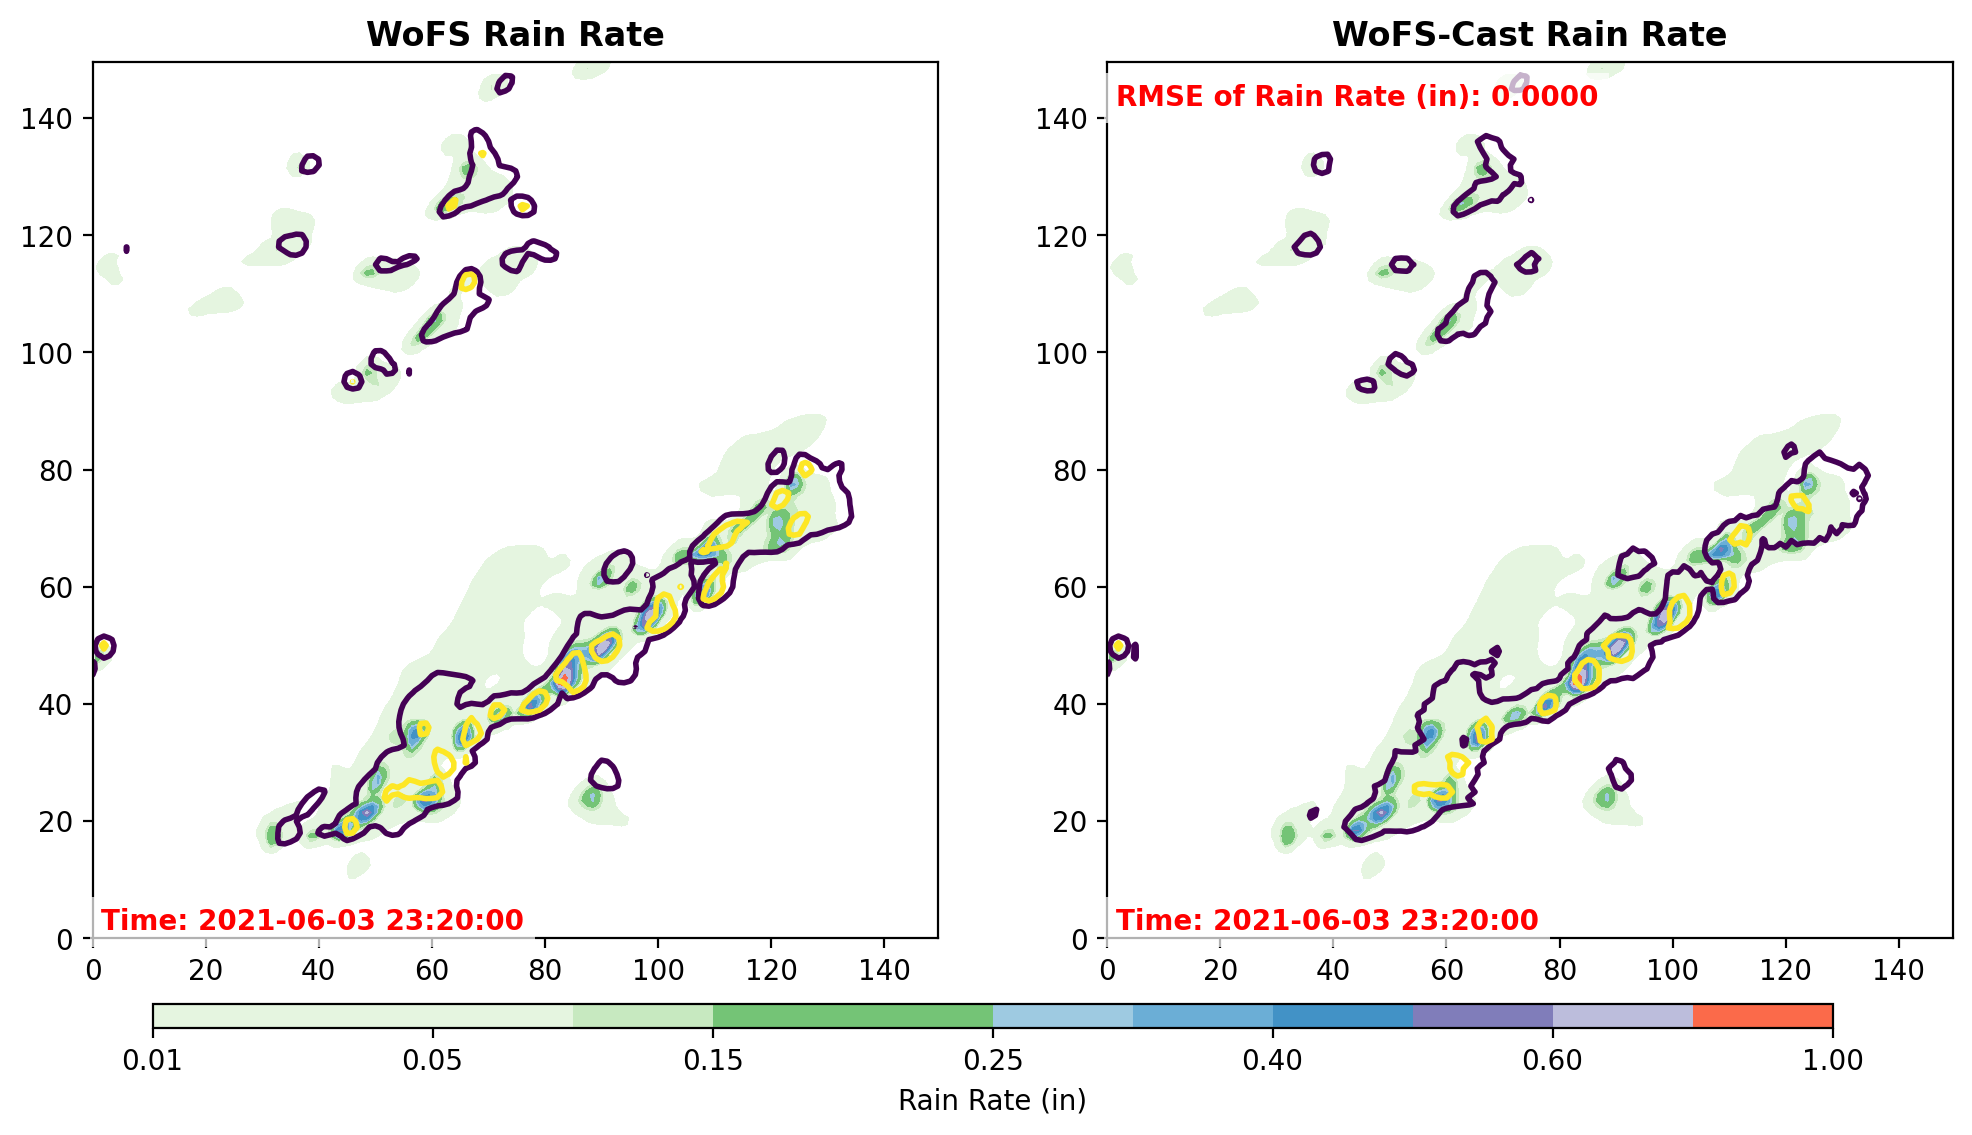

In [5]:
init_ds = inputs.squeeze(dim='batch', drop=True)
init_ds = init_ds.isel(time=[-1])
init_ds = init_ds.transpose('time', 'level', 'lat', 'lon')

preds = predictions.squeeze(dim='batch', drop=True)
tars = targets.squeeze(dim='batch', drop=True)

preds = preds.transpose('time', 'level', 'lat', 'lon')
tars = tars.transpose('time', 'level', 'lat', 'lon')

dts = to_datetimes(path, n_times = len(preds.time)+3)

#VARS_3D = ['U', 'V', 'W', 'T', 'GEOPOT', 'QVAPOR']
#VARS_2D = ['T2', 'COMPOSITE_REFL_10CM', 'UP_HELI_MAX', 'RAIN_AMOUNT']

var = 'RAIN_AMOUNT'
level = 'none'

level_txt=''
if level != 'none': 
    level_txt = f', level={level}'

titles = [f'WoFS {display_name_mapper.get(var, var)}{level_txt}', 
          f'WoFS-Cast {display_name_mapper.get(var, var)}{level_txt}']

# True plots the boundary condition region. 
plot_border=False

domain_size = model.task_config['domain_size']

# Function to get target and prediction pair with the selected level
def get_target_and_pred_pair(preds, targets, t, level=0):

    if level == 'max':
        zs = [targets[var][t].max(dim='level').values, preds[var][t].max(dim='level').values]
    elif level == 'min': 
        zs = [targets[var][t].min(dim='level').values, preds[var][t].min(dim='level').values]
    elif level == 'none':
        zs = [targets[var][t].values, preds[var][t].values]
    else:
        zs = [targets[var][t].isel(level=level).values, preds[var][t].isel(level=level).values]
        
    if var == 'RAIN_AMOUNT':
        # Convert from mm to inches.
        zs = [z/25.4 for z in zs]
    
    if var == 'T2':
        # convert K to F 
        zs = [(9.0/5.0*(z-273.15)) + 32.0 for z in zs]
    
    return zs 


# Adjust the subplot layout to make room for the colorbar
fig, axes = plt.subplots(dpi=200, figsize=(12, 6), ncols=2, 
                         gridspec_kw={'height_ratios': [1], 'bottom': 0.15})
plt.tight_layout()

# Determine global min and max values for consistent color scaling
zs = get_target_and_pred_pair(init_ds, init_ds, t=0, level=level)
global_min = np.percentile(zs, 1)
global_max = np.percentile(zs, 99)

if var == 'COMPOSITE_REFL_10CM':
    cmap = WoFSColors.nws_dz_cmap
    levels = WoFSLevels.dz_levels_nws
elif var == 'RAIN_AMOUNT':
    cmap = WoFSColors.rain_cmap
    levels = WoFSLevels.rain_rate_levels
elif var == 'UP_HELI_MAX':
    cmap = WoFSColors.wz_cmap_extend
    levels = WoFSLevels.uh_2to5_levels_3000m
elif var == 'T2': #or var == 'T':
    cmap = WoFSColors.temp_cmap
    levels = np.arange(40., 90., 2.5)
elif var == 'QVAPOR': 
    cmap = WoFSColors.temp_cmap
elif var == 'W': 
    cmap = WoFSColors.wz_cmap_extend
    levels = [2.5, 5, 10, 15, 20, 25, 30, 35, 40]
else:
    cmap = WoFSColors.wz_cmap_extend
    levels = 10 

# Create a colorbar axis at the bottom of the figure
# The values in `fig.add_axes` are [left, bottom, width, height], adjust as needed
cbar_ax = fig.add_axes([0.15, 0.075, 0.7, 0.02])

# Placeholder for the colorbar, to be created outside the update function
cbar = None
    
# Update function for the animation
def update(t):
    global cbar
    for ax in axes:
        ax.clear()

    if t==0:
        zs = get_target_and_pred_pair(init_ds, init_ds, t=0, level=level)
    else:    
        zs = get_target_and_pred_pair(preds, tars, t=t, level=level)
    
    
    diff = border_difference_check(zs[0], zs[1], BORDER_MASK)
    
    rmse = np.sqrt(np.mean((zs[0]-zs[1])**2))

    u_pred, v_pred = preds['U'][t].isel(level=0).values, preds['V'][t].isel(level=0).values
    u_tar, v_tar = tars['U'][t].isel(level=0).values, tars['V'][t].isel(level=0).values 
    u_pred = u_pred[::5, ::5]
    v_pred = v_pred[::5, ::5]
    u_tar = u_tar[::5, ::5]
    v_tar = v_tar[::5, ::5]
    wind_pred = (u_pred, v_pred)
    wind_tar = (u_tar, v_tar)
    winds = [wind_tar, wind_pred]
    x,y = np.meshgrid(np.arange(domain_size), np.arange(domain_size))
    x = x[::5, ::5]
    y = y[::5, ::5]
    
    dbz_pred = preds['COMPOSITE_REFL_10CM'][t].values
    dbz_tar = tars['COMPOSITE_REFL_10CM'][t].values
    
    dbzs = [dbz_tar, dbz_pred]
    
    color='white'
    for i, (ax, z, wind, dbz) in enumerate(zip(axes, zs, winds, dbzs)):
        
        if var in ['REFL_10CM', 'UP_HELI_MAX', 'COMPOSITE_REFL_10CM']:
            z = np.ma.masked_where(z < 1, z)
            color = 'black'

        im = ax.contourf(z, origin='lower', aspect='equal',
                       cmap=cmap, levels=levels)
 
        u,v = wind
        #ax.quiver(x,y, u, v, alpha=0.5)
        
        ax.set_title(titles[i], fontweight='bold')
        if i == 1:
            ax.annotate(f'RMSE of {display_name_mapper.get(var, var)} ({units_mapper.get(var,var)}): {rmse:.4f}', 
                        xy=(0.01, 0.95), xycoords='axes fraction', 
                        weight='bold', color='red', 
                       bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
            
            if plot_border: 
                ax.annotate(f'Border Diff: {diff:.4f}', xy=(0.01, 0.75), xycoords='axes fraction', 
                        weight='bold', color='black', 
                       bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
            
        ax.annotate(f'Time: {dts[t]}', xy=(0.01, 0.01), xycoords='axes fraction', 
                        weight='bold', color='red', fontsize=10, 
                   bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))    
        
        ax.contour(dbz, levels=[35, 50], linewidths=[2.0, 2.0])
        
        if plot_border:
            ax.imshow(BORDER_MASK, origin='lower', zorder=15, alpha=0.5)
        
        # Create or update the colorbar only once as it doesn't change with frames
        if cbar is None:
            cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
        cbar.set_label(f'{display_name_mapper.get(var, var)} ({units_mapper.get(var,var)})')

# Total number of frames
N = len(preds.time)  

# Create animation
anim = FuncAnimation(fig, update, frames=N, interval=200)

# To display the animation in a Jupyter notebook
from IPython.display import HTML
HTML(anim.to_jshtml())

# Optionally, to save the animation
#anim.save("wofscast.gif", writer="pillow", fps=5)